In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
bus_adjacency: BUS_ANY
incarnation: 12411741089843955467
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 10976981812
incarnation: 15131600553005061256
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0"
]


In [2]:
%matplotlib inline
from __future__ import print_function, division
path = "data/baidu/"
#path = "data/state/sample/"
import utils; reload(utils)
from utils import *
from IPython.display import FileLink
import cv2
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


In [3]:
train_path = 'data/baidu/image_contest_level_2_processed/'
label_exp_count = load_array('data/baidu/label_exp_num.data')

In [4]:
label_exp_files = []
for i, cnt in enumerate(label_exp_count):
    for c in range(cnt):
        label_exp_files.append('{}-{}-{}.png'.format(i, cnt-c, cnt))

In [5]:
label_path = 'data/baidu/level2_labels.txt'
raw_label_list = []
with open(label_path) as f:
    raw_label_list = f.readlines()
raw_label_list = [x.strip() for x in raw_label_list]
label_exp_num_length= []
exp_labels = []
exp_lens =[]
for line in raw_label_list:
    parts = line.split(' ')
    exprs = parts[0]
    result = parts[1]
    label_exp_num_length.append(len(exprs.split(';')))
    for exp in exprs.split(';'):
        exp_labels.append(exp.decode('utf8'))
        exp_lens.append(len(exp.decode('utf8')))

In [6]:
short_idxs = []
long_idxs = []
cursor = 0
for cnt in label_exp_count:
    for i in range(cnt):
        if i==cnt-1:
            long_idxs.append(cursor+i)
        else: 
            short_idxs.append(cursor+i)
    cursor = cursor + cnt
short_idxs = np.asarray(short_idxs)
long_idxs = np.asarray(long_idxs)

In [7]:
class DataGenator(keras.callbacks.Callback):
    
    def __init__(self, idxs, width, height):
        self.width = width
        self.height = height
        self.idxs = idxs
        self.label_length = max(np.asarray(exp_lens)[self.idxs])

        mask = np.random.rand(len(self.idxs)) < 0.9
        self.trn_idxs = self.idxs[mask]
        self.val_idxs = self.idxs[~mask]
        
        self.token_counts = {}
        for exp in np.asarray(exp_labels)[self.idxs]:
            for c in exp:
                if c in self.token_counts:
                    self.token_counts[c] += 1
                else:
                    self.token_counts[c] = 1
        self.tokens = sorted(self.token_counts.keys()) + ['N']
        self.zero_idx = len(self.tokens)-1
        
        
        self.token_idxs = dict()
        for i,token in enumerate(self.tokens):
            self.token_idxs[token] = i
            
        #所有的label都转化  但不会全部用上  用不上的为空
        self.actual_labels = np.full((len(exp_labels), self.label_length), self.zero_idx)
        for idx in idxs:
            for i, token in enumerate(exp_labels[idx]):
                self.actual_labels[idx][i] = self.token_idxs[token]
            
    def get_batch(self, batch_size, idxs, shuffle=True):
        if shuffle:  
            idxs = np.random.permutation(idxs)
        cur = 0
        idxs_len = len(idxs)
        while True:
            out = []
            next_cur = cur + batch_size
            if next_cur < idxs_len:
                out = idxs[cur: next_cur]
                cur = next_cur
            else:
                exceed = next_cur - idxs_len
                out = idxs[cur: idxs_len]
                if shuffle:  idxs = np.random.permutation(idxs)
                out = np.concatenate([out, idxs[0: exceed]]) 
                cur = exceed
            yield self.fetch_img_by_idxs(out), np.asarray(self.actual_labels)[out]
        
    def fetch_img_by_idxs(self, idxs):
        imgs = []
        for f in np.array(label_exp_files)[idxs]:
            img = cv2.imread(train_path+f)
            img = cv2.resize(img, (self.width, self.height), interpolation = cv2.INTER_LINEAR)
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            #img= np.expand_dims(img, axis=-1)
            img = np.transpose(np.asarray(img), (1, 0, 2))
            imgs.append(img)
        return np.array(imgs)
    
    
    def to_pretty_label(self, label):
        l = label.flatten().astype('int')
        s =''
        for token in l:
            if token != self.zero_idx:
                 s = s+self.tokens[token]
        return s    

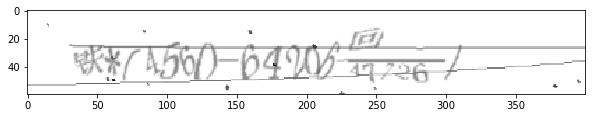

In [26]:
img_gen = DataGenator(idxs=using_idxs, width=img_w, height=img_h)
test_imgs = np.transpose(img_gen.fetch_img_by_idxs([1,2,4,5]), (0, 2, 1, 3)).reshape(-1, 60, 400)

f = plt.figure(figsize=(10,10), frameon=True)
plt.imshow(test_imgs[3])

In [8]:
### 决定使用什么类型的数据
using_idxs = long_idxs
img_label_data_prefix = 'all_long_2_3'
data_path = 'data/baidu/all-long-400-60/'

img_w = 300
img_h = 45

img_gen = DataGenator(idxs=using_idxs, width=img_w, height=img_h)

In [8]:
def save_raw_data():
    da = img_gen.get_batch(len(using_idxs), using_idxs, shuffle=False)
    imgs, labels = next(da)
    save_array('data/baidu/{}_imgs.dat'.format(img_label_data_prefix),  imgs)
    save_array('data/baidu/{}_labels.dat'.format(img_label_data_prefix), labels)

def load_raw_data():
    imgs = load_array('data/baidu/{}_imgs.dat'.format(img_label_data_prefix))
    labels = load_array('data/baidu/{}_labels.dat'.format(img_label_data_prefix))
    return (imgs, labels)
    
def save_split_data(x_trn, y_trn, x_val, y_val):

    save_array(data_path+"x_trn", x_trn)
    save_array(data_path+"y_trn", y_trn)


    save_array(data_path+"x_val", x_val)
    save_array(data_path+"y_val", y_val)

def load_split_data():

    x_trn = load_array(data_path+"x_trn")
    y_trn = load_array(data_path+"y_trn")

    x_val = load_array(data_path+"x_val")
    y_val = load_array(data_path+"y_val")
    
    return (x_trn, y_trn, x_val, y_val)

In [11]:
#save_raw_data()
imgs, labels = load_raw_data()

In [12]:
mask = np.random.rand(len(using_idxs)) < 0.9
idxs = np.random.permutation(len(using_idxs))
trn_idxs = idxs[mask]
val_idxs = idxs[~mask]


#da = img_gen.get_batch(len(using_idxs), using_idxs, shuffle=False)
#imgs, labels = next(da)

x_trn = imgs[trn_idxs]
y_trn = labels[trn_idxs]

x_val = imgs[val_idxs]
y_val = labels[val_idxs]

In [9]:
#save_split_data(x_trn, y_trn, x_val, y_val)
x_trn, y_trn, x_val, y_val = load_split_data()

In [10]:
x_trn.shape, y_trn.shape, x_val.shape, y_val.shape

((90059, 600, 90, 3), (90059, 30), (9941, 600, 90, 3), (9941, 30))

In [9]:
def show_data(x, y):  
    for i in range(len(x)):
        print(img_gen.to_pretty_label(y[i]))
        plots(np.expand_dims(x[i], axis=0))

In [10]:
def gen_label_length(labels):
    label_lengths = np.zeros((len(labels), 1))
    for i in range(len(labels)):
        label_lengths[i] = len(np.where(np.array(labels[i]) != img_gen.zero_idx)[0])
    return label_lengths.astype('uint8')

In [11]:
def map2seq(x):
    return K.reshape(K.permute_dimensions(x, (0, 3, 2, 1)), (x.shape[0], x.shape[-1], -1))

In [12]:
def map2seq_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 4  # only valid for 4D tensors
    return (shape[0], shape[-1], shape[1]*shape[2])

In [13]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

 zoom_range=0.05, shear_range=0.05, channel_shift_range=20,
                             rotation_range=5, height_shift_range=0.03, width_shift_range=0.03

In [14]:
batch_size = 64
da = image.ImageDataGenerator(zoom_range=0.05, shear_range=0.05,
                             channel_shift_range=20, rotation_range=5, 
                             height_shift_range=0.03, width_shift_range=0.03)
#da = image.ImageDataGenerator()
#x_trn_len = len(x_trn)//batch_size*batch_size
#trn_batches = da.flow(x_trn[:x_trn_len], y_trn[:x_trn_len], batch_size=batch_size, shuffle=True)

In [28]:
def trn_gen():
    trn_batches = img_gen.get_batch(batch_size, img_gen.trn_idxs, shuffle=False)
    #减2是因为进入ctc时  已经丢弃了2帧
    input_length = np.zeros([batch_size, 1]) + 66
    while True:
        x, y = next(trn_batches)
        x_tranformed = np.zeros(x.shape)
        for i, img in enumerate(x):            
            x_tranformed[i] = da.random_transform(img)
        label_length = gen_label_length(y)
        y[np.where(y==img_gen.zero_idx)] = 0
        yield [x_tranformed, y, input_length, label_length], np.zeros([batch_size])

In [29]:
val_data_batches = img_gen.get_batch(len(img_gen.val_idxs), img_gen.val_idxs, shuffle=False)
x_val, y_val = next(val_data_batches)
size = len(x_val)
#减2是因为进入ctc时  已经丢弃了2帧
x_val_input_length = np.zeros([size, 1]) + 66
y_val_label_length = gen_label_length(y_val)
def val_data():
    return [x_val, y_val, x_val_input_length, y_val_label_length], np.zeros([size])

In [61]:
batches = trn_gen()
def inspect_trn_data():
    batch = next(batches)[0]
    img = batch[0][0]
    label = batch[1][0]
    il =batch[2][0]
    ll  =batch[3][0]
    print(img.shape)
    plots(np.expand_dims(np.transpose(img, (1,0,2)), axis=0))
    print(label)
    print(img_gen.to_pretty_label(label))
    print(il)
    print(ll)
def inspect_val_data():
    batch = val_data()[0]
    img = batch[0][0]
    label = batch[1][0]
    il =batch[2][0]
    ll  =batch[3][0]
    print(img.shape)
    plots(np.expand_dims(np.transpose(img, (1,0,2)), axis=0))
    print(label)
    print(img_gen.to_pretty_label(label))
    print(il)
    print(ll)

(400, 60, 1)


TypeError: Invalid dimensions for image data

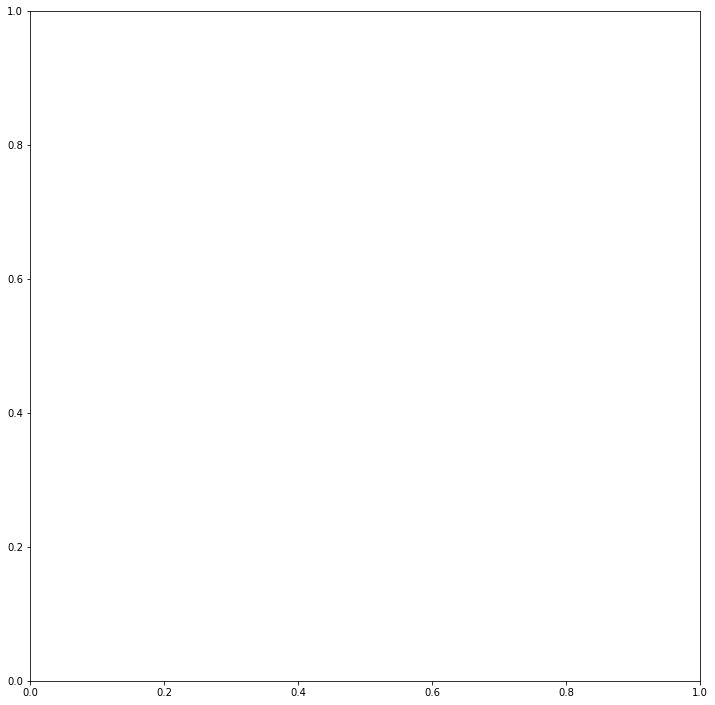

In [18]:
inspect_trn_data()
inspect_val_data()

In [17]:
def is_long_label(label):
    return not(len(np.where(label > 0)[0]) < 10)

In [18]:
def evaluate(base_model, batch_num=None):
    [X_test, y_test, _, label_length], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    pred = base_model.predict(X_test[:batch_num])
    correct_number = 0
    correct_long_n = 0
    total_long_n = 0
    correct_short_n = 0
    total_short_n = 0
    
    shape = pred[:,2:,:].shape
    out = K.get_value(K.ctc_decode(pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])
    
    for j in range(out.shape[0]):
        
        #-1 是ctc返回的  代表empty
        l = out[j][np.where(out[j] != -1)[0]]
        equal =  label_length[j] == len(l) and np.array_equal(l, y_test[j][:label_length[j][0]])
        
        is_long = is_long_label(y_test[j])
        if is_long:
            total_long_n=total_long_n+1
        else:
            total_short_n=total_short_n+1
        if equal:
            correct_number = correct_number+1
            if is_long:
                correct_long_n=correct_long_n+1
            else:
                correct_short_n=correct_short_n+1
    l = 0
    s = 0
    if total_long_n>0: l=correct_long_n/total_long_n
    if total_short_n>0: s=correct_short_n/total_short_n
    
    return correct_number/batch_num, s, l

In [19]:
from keras.callbacks import *

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc, s, l = evaluate(base_model)
        self.accs.append(acc)
        acc = acc *100
        s = s * 100
        l = l * 100
        print(' acc: {}% long: {}% short: {}%'.format(acc, s, l))
        
        if acc > 95:
            model.save_weights('v{}.wgt'.format(epoch))

evaluator = Evaluate()

In [37]:

input_shape=(img_gen.width, img_gen.height, 3)
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = BatchNormalization()(input_data)

inner = Convolution2D(32, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(32, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D()(inner)

inner = Convolution2D(64, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(64, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D()(inner)

inner = Convolution2D(128, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(128, 3, 3)(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D((1,2))(inner)

inner = Convolution2D(256, 3, 3, border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = Convolution2D(256, 3, 3, border_mode='same')(inner)
inner = BatchNormalization()(inner)
inner = MaxPooling2D((1,2))(inner)


ctc_time_lenght = 68
inner = Reshape((ctc_time_lenght, -1))(inner)

inner = Bidirectional(LSTM(512, return_sequences=True, inner_init='identity'), merge_mode='sum')(inner)
inner = BatchNormalization()(inner)


y_pred = Dense(len(img_gen.tokens), activation='softmax')(inner)

base_model = Model(input=input_data, output=y_pred)

labels = Input(name='the_labels', shape=(img_gen.label_length,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64') 

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

model = Model([input_data, labels, input_length, label_length], loss_out)
    
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
the_input (InputLayer)           (None, 300, 45, 3)    0                                            
____________________________________________________________________________________________________
batchnormalization_62 (BatchNorm (None, 300, 45, 3)    12          the_input[0][0]                  
____________________________________________________________________________________________________
convolution2d_50 (Convolution2D) (None, 298, 43, 32)   896         batchnormalization_62[0][0]      
____________________________________________________________________________________________________
batchnormalization_63 (BatchNorm (None, 298, 43, 32)   128         convolution2d_50[0][0]           
___________________________________________________________________________________________

In [25]:
x_trn_len = ((len(img_gen.trn_idxs)//batch_size)/10) * batch_size
x_val_len = ((len(img_gen.val_idxs)//batch_size)/10) * batch_size * 2
#x_trn_len = len(img_gen.trn_idxs)//batch_size * batch_size
#x_val_len = len(img_gen.val_idxs)//batch_size* batch_size

In [36]:
class LossHistory(keras.callbacks.Callback):
    def __init__(self):
        self.losses = []        

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))


## 6-cnn-32-128 + 1-512-rnn


In [30]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)

Epoch 1/15
9024/8992 [==============================] - 75s - loss: 84.8132    

/home/viiv/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/15
9024/8992 [==============================] - 70s - loss: 35.5333    
Epoch 3/15
9024/8992 [==============================] - 69s - loss: 19.8717    
Epoch 4/15
9024/8992 [==============================] - 70s - loss: 14.3207    
Epoch 5/15
9024/8992 [==============================] - 69s - loss: 11.6939    
Epoch 6/15
9024/8992 [==============================] - 71s - loss: 9.8787    
Epoch 7/15
9024/8992 [==============================] - 70s - loss: 9.0695    
Epoch 8/15
9024/8992 [==============================] - 69s - loss: 8.2294    
Epoch 9/15
9024/8992 [==============================] - 70s - loss: 7.5627    
Epoch 10/15
9024/8992 [==============================] - 70s - loss: 7.0714    
Epoch 11/15
9024/8992 [==============================] - 64s - loss: 6.6152    
Epoch 12/15
9024/8992 [==============================] - 70s - loss: 6.6239    
Epoch 13/15
9024/8992 [==============================] - 70s - loss: 6.2170    
Epoch 14/15
9024/8992 [====================

10079/10079 [==============================] - 17s    
3.46288794451
 acc: 45.5402321659% long: 0% short: 45.5402321659%


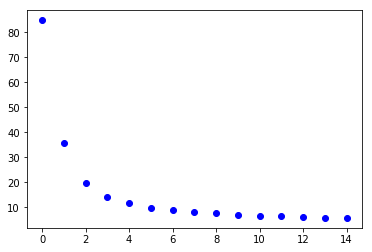

In [31]:
vx, vy = val_data()
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(30)
loss = history1.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'bo')
plt.show()

Epoch 1/15
9024/8992 [==============================] - 70s - loss: 5.5148    
Epoch 2/15
9024/8992 [==============================] - 70s - loss: 5.3983    
Epoch 3/15
9024/8992 [==============================] - 67s - loss: 5.2977    
Epoch 4/15
9024/8992 [==============================] - 70s - loss: 5.0214    
Epoch 5/15
9024/8992 [==============================] - 70s - loss: 5.0465    
Epoch 6/15
9024/8992 [==============================] - 70s - loss: 4.8848    
Epoch 7/15
9024/8992 [==============================] - 66s - loss: 4.7425    
Epoch 8/15
9024/8992 [==============================] - 70s - loss: 4.6841    
Epoch 9/15
9024/8992 [==============================] - 68s - loss: 4.5831    
Epoch 10/15
9024/8992 [==============================] - 69s - loss: 4.4700    
Epoch 11/15
9024/8992 [==============================] - 70s - loss: 4.3330    
Epoch 12/15
9024/8992 [==============================] - 69s - loss: 4.3908    
Epoch 13/15
9024/8992 [==========================

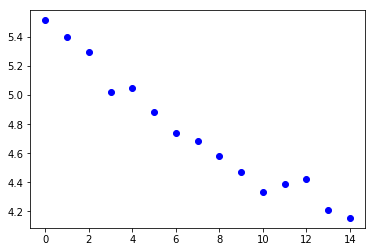

In [32]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
vx, vy = val_data()
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(30)
loss = history1.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'bo')
plt.show()

# 8-cnn-32-256 + 1-512-rnn

Epoch 1/15
9024/8992 [==============================] - 73s - loss: 92.5822    
Epoch 2/15
9024/8992 [==============================] - 69s - loss: 48.3729    
Epoch 3/15
9024/8992 [==============================] - 68s - loss: 25.7566    
Epoch 4/15
9024/8992 [==============================] - 69s - loss: 17.3959    
Epoch 5/15
9024/8992 [==============================] - 68s - loss: 13.5335    
Epoch 6/15
9024/8992 [==============================] - 68s - loss: 11.1948    
Epoch 7/15
9024/8992 [==============================] - 68s - loss: 9.7624    
Epoch 8/15
9024/8992 [==============================] - 63s - loss: 8.8075    
Epoch 9/15
9024/8992 [==============================] - 68s - loss: 7.9313    
Epoch 10/15
9024/8992 [==============================] - 68s - loss: 7.3602    
Epoch 11/15
9024/8992 [==============================] - 69s - loss: 6.9026    
Epoch 12/15
9024/8992 [==============================] - 69s - loss: 6.5420    
Epoch 13/15
9024/8992 [====================

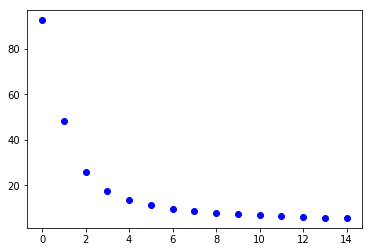

In [38]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
vx, vy = val_data()
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(30)
loss = history1.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'bo')
plt.show()

Epoch 1/15
9024/8992 [==============================] - 68s - loss: 5.3678    
Epoch 2/15
9024/8992 [==============================] - 64s - loss: 5.3018    
Epoch 3/15
9024/8992 [==============================] - 68s - loss: 5.0619    
Epoch 4/15
9024/8992 [==============================] - 67s - loss: 4.8063    
Epoch 5/15
9024/8992 [==============================] - 68s - loss: 4.7633    
Epoch 6/15
9024/8992 [==============================] - 68s - loss: 4.5610    
Epoch 7/15
9024/8992 [==============================] - 69s - loss: 4.5103    
Epoch 8/15
9024/8992 [==============================] - 68s - loss: 4.3947    
Epoch 9/15
9024/8992 [==============================] - 68s - loss: 4.2891    
Epoch 10/15
9024/8992 [==============================] - 68s - loss: 4.2081    
Epoch 11/15
9024/8992 [==============================] - 68s - loss: 4.1017    
Epoch 12/15
9024/8992 [==============================] - 68s - loss: 4.1599    
Epoch 13/15
9024/8992 [==========================

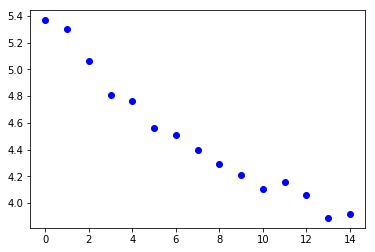

In [39]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
vx, vy = val_data()
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(30)
loss = history1.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'bo')
plt.show()

#  9-cnn-64-512    2-256-rnn

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30)



Epoch 1/30
9024/8992 [==============================] - 127s - loss: 99.9664    
Epoch 2/30
9024/8992 [==============================] - 128s - loss: 59.6732   
Epoch 3/30
9024/8992 [==============================] - 128s - loss: 35.7162   
Epoch 4/30
9024/8992 [==============================] - 152s - loss: 21.3635   
Epoch 5/30
9024/8992 [==============================] - 152s - loss: 14.8342   
Epoch 6/30
9024/8992 [==============================] - 152s - loss: 11.5182   
Epoch 7/30
9024/8992 [==============================] - 152s - loss: 9.4364   
Epoch 8/30
9024/8992 [==============================] - 152s - loss: 8.3076   
Epoch 9/30
9024/8992 [==============================] - 151s - loss: 7.2707   
Epoch 10/30
9024/8992 [==============================] - 151s - loss: 6.6296   
Epoch 11/30
9024/8992 [==============================] - 137s - loss: 5.9807   
Epoch 12/30
9024/8992 [==============================] - 125s - loss: 5.5614   
Epoch 13/30
9024/8992 [===================

NameError: name 'xy' is not defined

In [39]:
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(10)

10050/10050 [==============================] - 46s    
1.35222773166
 acc: 68.447761194% long: 0% short: 68.447761194%


# 9-cnn-64-512 1-512-rnn    no-data-augamentation

In [42]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(10)

Epoch 1/15
9024/8992 [==============================] - 107s - loss: 76.5256   
Epoch 2/15
9024/8992 [==============================] - 104s - loss: 30.1881   
Epoch 3/15
9024/8992 [==============================] - 104s - loss: 20.0389   
Epoch 4/15
9024/8992 [==============================] - 104s - loss: 16.0240   
Epoch 5/15
9024/8992 [==============================] - 104s - loss: 13.0939   
Epoch 6/15
9024/8992 [==============================] - 103s - loss: 9.7932   
Epoch 7/15
9024/8992 [==============================] - 104s - loss: 7.1038   
Epoch 8/15
9024/8992 [==============================] - 103s - loss: 5.3637   
Epoch 9/15
9024/8992 [==============================] - 103s - loss: 4.0550   
Epoch 10/15
9024/8992 [==============================] - 104s - loss: 3.3188   
Epoch 11/15
9024/8992 [==============================] - 98s - loss: 2.9263    
Epoch 12/15
9024/8992 [==============================] - 102s - loss: 2.7580   
Epoch 13/15
9024/8992 [=====================

# 9-cnn-64-512 1-512-rnn  no-data-augamentation  dropout 0.2

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(10)

Epoch 1/15
9024/8992 [==============================] - 108s - loss: 82.1191   
Epoch 2/15
9024/8992 [==============================] - 93s - loss: 31.4453    
Epoch 3/15
9024/8992 [==============================] - 86s - loss: 20.4815    
Epoch 4/15
9024/8992 [==============================] - 86s - loss: 16.7978    
Epoch 5/15
9024/8992 [==============================] - 86s - loss: 14.2901    
Epoch 6/15
6784/8992 [=====================>........] - ETA: 21s - loss: 11.9260

In [47]:
history1.history

{'loss': [82.119107672508733,
  31.44530929403102,
  20.481513084249293,
  16.79782994588216,
  14.290107030395076,
  11.504723589471046,
  8.7697446227919134,
  6.4063071934043938,
  5.1893428893799474,
  3.971756120100089,
  3.2877366001724351,
  3.044551298973408,
  2.7796175530616272,
  2.4218144788809703,
  2.5285970623611558]}

In [48]:
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(10)

10048/10050 [============================>.] - ETA: 0s2.43480613743
 acc: 52.7462686567% long: 0% short: 52.7462686567%


In [49]:
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=30)
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(10)

Epoch 1/30
9024/8992 [==============================] - 105s - loss: 2.0761   
Epoch 2/30
9024/8992 [==============================] - 104s - loss: 2.0007   
Epoch 3/30
9024/8992 [==============================] - 104s - loss: 1.8460   
Epoch 4/30
9024/8992 [==============================] - 104s - loss: 1.7150   
Epoch 5/30
9024/8992 [==============================] - 105s - loss: 1.7219   
Epoch 6/30
9024/8992 [==============================] - 104s - loss: 1.7782   
Epoch 7/30
9024/8992 [==============================] - 105s - loss: 1.6543   
Epoch 8/30
9024/8992 [==============================] - 105s - loss: 1.6461   
Epoch 9/30
9024/8992 [==============================] - 104s - loss: 1.5105   
Epoch 10/30
9024/8992 [==============================] - 104s - loss: 1.4885   
Epoch 11/30
9024/8992 [==============================] - 94s - loss: 1.3563    
Epoch 12/30
9024/8992 [==============================] - 86s - loss: 1.3986    
Epoch 13/30
9024/8992 [==========================

KeyboardInterrupt: 

In [50]:
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(10)

10048/10050 [============================>.] - ETA: 0s1.55165211453
 acc: 68.6268656716% long: 0% short: 68.6268656716%


# 9-cnn-64-512 1-512-rnn  no-data-augamentation  dropout 0.5

In [53]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='rmsprop')
history1 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=15)
print(model.evaluate(vx, vy))
evaluator.on_epoch_end(10)

Epoch 1/15
9024/8992 [==============================] - 108s - loss: 83.2673   
Epoch 2/15
9024/8992 [==============================] - 105s - loss: 37.8248   
Epoch 3/15
9024/8992 [==============================] - 106s - loss: 22.3476   
Epoch 4/15
9024/8992 [==============================] - 105s - loss: 18.5904   
Epoch 5/15
9024/8992 [==============================] - 105s - loss: 16.1836   
Epoch 6/15
9024/8992 [==============================] - 104s - loss: 13.8324   
Epoch 7/15
9024/8992 [==============================] - 104s - loss: 11.4701   
Epoch 8/15
9024/8992 [==============================] - 86s - loss: 9.3513    
Epoch 9/15
9024/8992 [==============================] - 86s - loss: 7.4384    
Epoch 10/15
9024/8992 [==============================] - 86s - loss: 6.4672    
Epoch 11/15
9024/8992 [==============================] - 86s - loss: 5.1457    
Epoch 12/15
9024/8992 [==============================] - 86s - loss: 4.6310    
Epoch 13/15
9024/8992 [===================

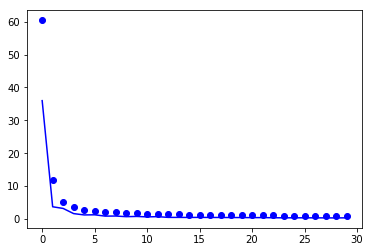

In [66]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')

plt.show()


In [ ]:
model.optimizer.lr=0.00001
history3 = model.fit_generator(trn_gen(), x_trn_len, nb_epoch=20, callbacks=[evaluator],
                    validation_data=val_data(), nb_val_samples=x_val_len)

Epoch 1/20
215488/215552 [============================>.] - ETA: 0s - loss: 2.5804[ 0 39  5 13 13  7 12  9  2  0  0  8  7  7 14 11  2  8  6 10 11 15  1  1  2 11 14  6 11 11  1]
[ 0 14 10 13 15  8  2  0  0 10  8 14  9 14  4 39  5 11  9  6  8  6  1  1  4  1 14  9 10 10  1]
 acc: 69.959228%
 short: 91.786268%
 l: 33.765363%
215552/215552 [==============================] - 824s - loss: 2.5802 - val_loss: 1.9581
Epoch 2/20
215488/215552 [============================>.] - ETA: 0s - loss: 3.6731[ 0 19  5 13 13  7 12 15  2  0  0  8  7  7 14 11  2  8  6 10 11 15  1  1  2 11 14  6 11 11  1]
[ 0  9 11 10 13  8  2  7 15 14  7 15  1  4  0  9 13 14 14 13  1  2 25  5 13  7 10  6 13 15  1]
[ 0  9  7  7 12  6  6  3  0 27  5 13  7  6  6 12  2 11  6  7 14  6  1  1  4 12 10  7 13  8  1]
 acc: 71.535455%
 short: 90.802507%
 l: 39.586592%
215552/215552 [==============================] - 825s - loss: 3.6725 - val_loss: 1.6757
Epoch 3/20
215488/215552 [============================>.] - ETA: 0s - loss: 2.2219 

KeyboardInterrupt: 

In [26]:
def show_result(base_model, batch_num=None):
    [X_test, y_test, _, _], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    out = base_model.predict(X_test[:batch_num])
    correct_number = 0
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = np.array([k for k, g in itertools.groupby(out_best)])
        l = out_best[np.where(out_best != img_gen.zero_idx)[0]]
        
        print(img_gen.to_pretty_label(l))
        plots(np.expand_dims(np.transpose(X_test[j], (1,0,2)), axis=0))
    

In [113]:
def show_wrong_result(base_model, batch_num=None):
    [X_test, y_test, _, label_length], _  = val_data()
    if batch_num is None: batch_num = len(X_test)
    pred = base_model.predict(X_test[:batch_num])
    correct_number = 0
    
    shape = pred[:,2:,:].shape
    out = K.get_value(K.ctc_decode(pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])
    
    for j in range(out.shape[0]):
        l = out[j][np.where(out[j] != -1)[0]]
        
        if label_length[j] != len(l) or not np.array_equal(l, y_test[j][:label_length[j][0]]):
            print(u'{}  {}'.format(img_gen.to_pretty_label(l), img_gen.to_pretty_label(y_test[j])))
            plt.figure(figsize=(10,60), frameon=True)
            plt.imshow(X_test[j].transpose(1,0,2).reshape(60,400))
            #plots(np.expand_dims(np.transpose(X_test[j], (1,0,2)), axis=0))
            
    

柳=29839
柳=6075
91656+(82642-(回/46950+8842))
锁=67574
塘*(复/85814-77494-43109)
柳-(65454*(奔/26836-7834))
水=22871
锁=35473
深=44448
((81984+27327)-烧)*奔/43062


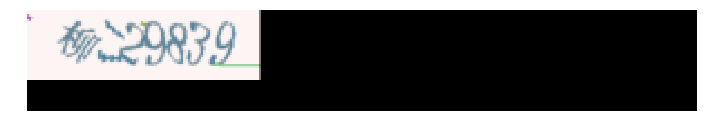

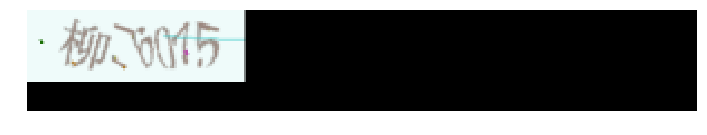

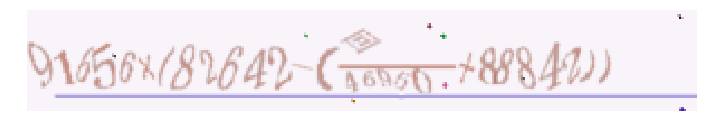

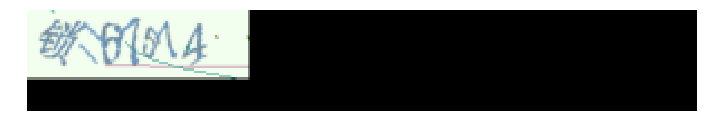

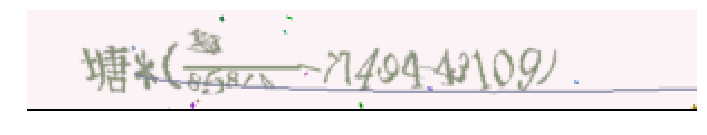

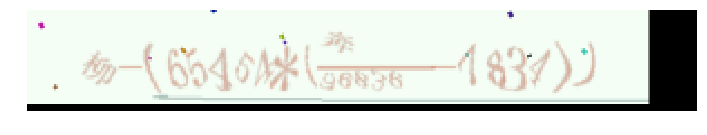

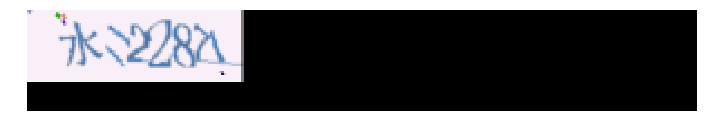

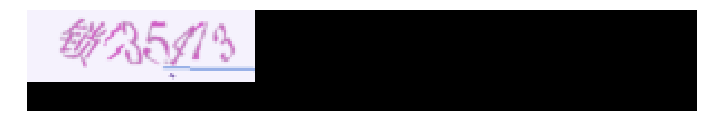

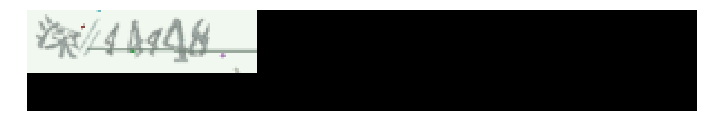

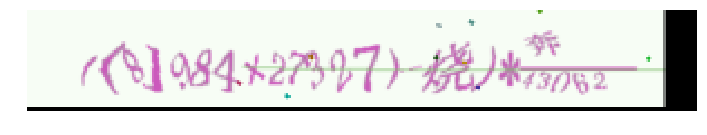

In [70]:
show_result(base_model, 10)

57773+((55158+之/98192)-6984)  57773+((55158+之/98192)-69841)
奔/40121*((36918-72655)-烧)  水/49121*((36918-72655)-烧)
君/417143*(塘-11240*37636)  回/42143*(塘-11240*37636)
46012*(74074+深)*上/83551  46012*(74074+深)*上/83557
到/85225+((48129+15941)-铁)  到/85225+((48129+15947)-铁)


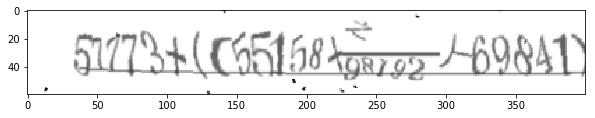

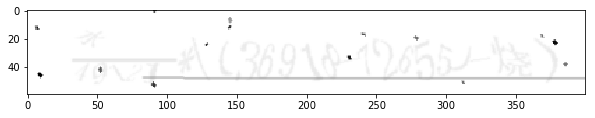

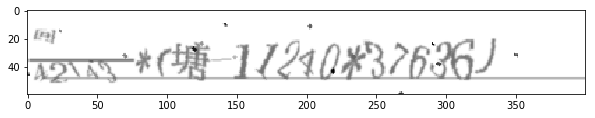

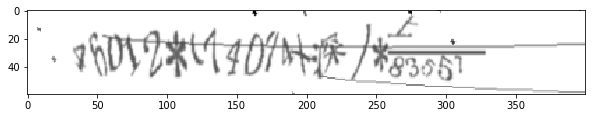

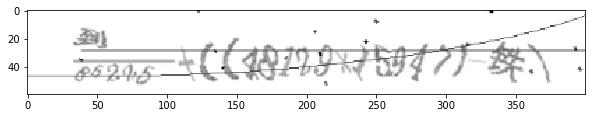

In [115]:
show_wrong_result(base_model, 20)

In [61]:
model.save_weights('l2_first_54.wgt')

In [92]:
model.load_weights('l2_first_54.wgt')

In [95]:
model.save('l2_first_54.h5')

In [59]:
model.save_weights('xxx.wgt')

In [22]:
model.load_weights('xxx.wgt')

In [ ]:
model